<a href="https://colab.research.google.com/github/pattrickx/CNN_CIFAR10/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mnist


In [81]:
from sklearn.datasets import load_digits
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Subset


In [82]:

data_transform = transforms.Compose([
                                     transforms.Resize(32),
                                     transforms.ToTensor(),])
dataset_train = datasets.CIFAR10("./data", 
                      train=True, 
                      transform=data_transform, 
                      download=True)

dataset_test = datasets.CIFAR10("./data", 
                      train=False, 
                      transform=data_transform, 
                      download=False)
idx,y =[],[]
for i in range(10000):
    idx.append(i)
    y.append(dataset_test[i][1])

test_idx,valid_idx,_ , _ = train_test_split(idx,y,test_size=0.5,stratify=y)

dataset_valid = Subset(dataset_test, valid_idx)
dataset_test = Subset(dataset_test, test_idx)

Files already downloaded and verified


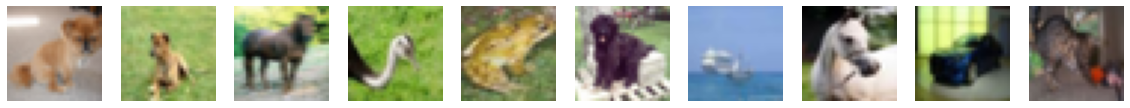

In [83]:
fig, axs = plt.subplots(1,10, figsize=(20, 2))
for i in range(10):
    data, label = dataset_test[i]
    axs[i].imshow(data.permute((1,2,0)))
    axs[i].axis('off')

In [84]:
n_classes=10

In [85]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,  TensorDataset

batch_size = 50


dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train),batch_size=batch_size) 
dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test),batch_size=batch_size) 
dataloader_valid = DataLoader(dataset_valid, sampler=SequentialSampler(dataset_valid),batch_size=batch_size) 

## Model

In [86]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np


In [87]:
class MLP(nn.Module):
    def __init__(self,  hidden_channels, out_channels, num_layers, dropout):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=6),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5),
            nn.BatchNorm2d(120),
            nn.ReLU(),

            nn.Flatten()
        )

        self.features = nn.Sequential(
            nn.Linear(120, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
            )
        
        for _ in range(num_layers):
        
            self.features.append(nn.Linear(hidden_channels, hidden_channels))
            self.features.append(nn.BatchNorm1d(hidden_channels))
            self.features.append(nn.ReLU())
            self.features.append(nn.Dropout(dropout))

        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, out_channels),
            nn.LogSoftmax(dim=-1))
        
    def forward(self, X):
        X = self.conv(X)
        X = self.features(X)
        return self.classifier(X)

## DEfinitions

In [88]:
args_device = 0
device = f'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda')

In [89]:
hidden_channels = 256
num_layers = 2
dropout = 0.2
lr = 1e-3
weight_decay = 1e-3
n_classes=10

model = MLP(  hidden_channels, n_classes , num_layers, dropout)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
model = model.to(device)



## Train

In [90]:
import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import time
import pandas as pd

In [91]:
def training_loop(model,dataloader_train,epoch):
    running_loss = 0.
    running_accuracy = 0.

    progress_bar = tqdm.tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=True, disable=False)
    for bach in progress_bar:

        inputs, labels = bach
                
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
        
        accuracy = accuracy_score(outputs.argmax(dim=-1, keepdim=True).cpu().numpy(), labels.cpu().numpy())
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(inputs)),
                                  'accuracy score': '{:.3f}'.format(accuracy)})
         

        running_accuracy += accuracy

    # Imprimindo os dados referentes a esta época
    tqdm.tqdm.write(f'Train loss: {running_loss/len(dataloader_train)}')
    tqdm.tqdm.write(f'Train accuracy score: {running_accuracy/len(dataloader_train)}')

    return running_accuracy/len(dataloader_train),running_loss/len(dataloader_train)

In [92]:
def valid_loop(model,dataloader_test):

    loss_test_total = 0
    predictions, true_test = [], []
    test_f1=0
    with torch.no_grad(): 
        progress_bar = tqdm.tqdm(dataloader_test, desc='Valid: ', leave=False, disable=False)
        for bach in progress_bar:

            inputs, labels = bach
                    
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward
            outputs = model(inputs)

            test_loss = criterion(outputs, labels)

            loss_test_total += test_loss.item()
            predictions.append(outputs.argmax(dim=-1, keepdim=True).cpu().numpy())
            true_test.append(labels.cpu().numpy())

            progress_bar.set_postfix({'test_loss': '{:.3f}'.format(test_loss.item()/len(inputs))})

        loss_test_avg = loss_test_total/len(dataloader_test)
        predictions = np.concatenate(predictions, axis=0)
        true_test = np.concatenate(true_test, axis=0)

        test_f1 = f1_score(true_test, predictions, average='weighted')
        test_f1_macro = f1_score(true_test, predictions, average='macro')
        test_accuracy_score = accuracy_score(true_test, predictions)
        tqdm.tqdm.write(f'Test loss: {test_loss}')
        tqdm.tqdm.write(f'accuracy score: {test_accuracy_score}')
        tqdm.tqdm.write(f'F1 Score (Weighted): {test_f1}')
        tqdm.tqdm.write(f'F1 Score (Macro): {test_f1_macro}')
        # torch.save(model.state_dict(), f'./data/MLP_node_{epoch}.model')
        torch.save(model.state_dict(), f'./CNN_CIFAR10.model')

  
    return test_accuracy_score,loss_test_avg,test_f1

In [93]:
epochs = 50
best_f1=0
best_model = None
history = []

In [94]:

for epoch in range(epochs):
    start = time.time()

    model.train()
    ac_train,loss_train = training_loop(model,dataloader_train, epoch)
    

    model.eval()
    ac_val,loss_val,f1 =  valid_loop(model,dataloader_test)

    history.append([loss_train,ac_train,loss_val,ac_val])
    if f1>best_f1:
        best_f1=f1
        best_model = model
        torch.save(model.state_dict(), f'./BEST_CNN_CIFAR10.model')

Epoch 0: 100%|██████████| 1000/1000 [00:18<00:00, 53.98it/s, training_loss=0.026, accuracy score=0.520]


Train loss: 1.5457957627773284
Train accuracy score: 0.4388600000000004


Test loss: 1.6261600255966187
accuracy score: 0.4858
F1 Score (Weighted): 0.49293120136764984
F1 Score (Macro): 0.49293120136764984


Epoch 1: 100%|██████████| 1000/1000 [00:17<00:00, 56.57it/s, training_loss=0.021, accuracy score=0.660]


Train loss: 1.2916932837963104
Train accuracy score: 0.544260000000001


Test loss: 1.6383278369903564
accuracy score: 0.516
F1 Score (Weighted): 0.5227074916420825
F1 Score (Macro): 0.5227074916420824


Epoch 2: 100%|██████████| 1000/1000 [00:18<00:00, 52.84it/s, training_loss=0.022, accuracy score=0.580]


Train loss: 1.1913497926592826
Train accuracy score: 0.5794600000000012


Test loss: 1.459495186805725
accuracy score: 0.5888
F1 Score (Weighted): 0.5863396494785788
F1 Score (Macro): 0.5863396494785788


Epoch 3: 100%|██████████| 1000/1000 [00:18<00:00, 54.97it/s, training_loss=0.020, accuracy score=0.640]


Train loss: 1.1288608939051628
Train accuracy score: 0.6050400000000002


Test loss: 1.2782025337219238
accuracy score: 0.605
F1 Score (Weighted): 0.5966212559165226
F1 Score (Macro): 0.5966212559165227


Epoch 4: 100%|██████████| 1000/1000 [00:17<00:00, 56.35it/s, training_loss=0.032, accuracy score=0.480]


Train loss: 1.084062234520912
Train accuracy score: 0.6224800000000007


Test loss: 1.6268609762191772
accuracy score: 0.512
F1 Score (Weighted): 0.5195414923961025
F1 Score (Macro): 0.5195414923961025


Epoch 5: 100%|██████████| 1000/1000 [00:18<00:00, 54.01it/s, training_loss=0.019, accuracy score=0.700]


Train loss: 1.0474760218858719
Train accuracy score: 0.637580000000001


Test loss: 1.3261406421661377
accuracy score: 0.6024
F1 Score (Weighted): 0.5876282213194203
F1 Score (Macro): 0.5876282213194205


Epoch 6: 100%|██████████| 1000/1000 [00:17<00:00, 56.95it/s, training_loss=0.016, accuracy score=0.800]


Train loss: 1.0179802315235138
Train accuracy score: 0.6472000000000014


Test loss: 1.1407891511917114
accuracy score: 0.6338
F1 Score (Weighted): 0.6299755181353572
F1 Score (Macro): 0.6299755181353572


Epoch 7: 100%|██████████| 1000/1000 [00:17<00:00, 56.38it/s, training_loss=0.017, accuracy score=0.700]


Train loss: 0.9884498776197433
Train accuracy score: 0.6594000000000012


Test loss: 1.2017238140106201
accuracy score: 0.6324
F1 Score (Weighted): 0.6301070498026966
F1 Score (Macro): 0.6301070498026966


Epoch 8: 100%|██████████| 1000/1000 [00:18<00:00, 54.25it/s, training_loss=0.022, accuracy score=0.640]


Train loss: 0.9651991456151009
Train accuracy score: 0.6653000000000007


Test loss: 1.224381685256958
accuracy score: 0.6252
F1 Score (Weighted): 0.6236770583545
F1 Score (Macro): 0.6236770583545002


Epoch 9: 100%|██████████| 1000/1000 [00:17<00:00, 56.51it/s, training_loss=0.015, accuracy score=0.820]


Train loss: 0.9497681131362915
Train accuracy score: 0.6723000000000013


Test loss: 1.256548285484314
accuracy score: 0.6276
F1 Score (Weighted): 0.6274055242128458
F1 Score (Macro): 0.6274055242128458


Epoch 10: 100%|██████████| 1000/1000 [00:17<00:00, 56.21it/s, training_loss=0.023, accuracy score=0.580]


Train loss: 0.9333294633924961
Train accuracy score: 0.6796200000000016


Test loss: 1.2044389247894287
accuracy score: 0.633
F1 Score (Weighted): 0.6260066664360724
F1 Score (Macro): 0.6260066664360725


Epoch 11: 100%|██████████| 1000/1000 [00:18<00:00, 54.50it/s, training_loss=0.017, accuracy score=0.720]


Train loss: 0.9143657776415348
Train accuracy score: 0.6864400000000005


Test loss: 1.240215539932251
accuracy score: 0.6396
F1 Score (Weighted): 0.636900304286082
F1 Score (Macro): 0.636900304286082


Epoch 12: 100%|██████████| 1000/1000 [00:17<00:00, 56.30it/s, training_loss=0.022, accuracy score=0.580]


Train loss: 0.9050581538677216
Train accuracy score: 0.6888800000000006


Test loss: 1.3068594932556152
accuracy score: 0.6252
F1 Score (Weighted): 0.6261398746157758
F1 Score (Macro): 0.6261398746157758


Epoch 13: 100%|██████████| 1000/1000 [00:18<00:00, 54.10it/s, training_loss=0.020, accuracy score=0.700]


Train loss: 0.8855300984680653
Train accuracy score: 0.6948200000000001


Test loss: 1.440325140953064
accuracy score: 0.617
F1 Score (Weighted): 0.6030744962323331
F1 Score (Macro): 0.6030744962323332


Epoch 14: 100%|██████████| 1000/1000 [00:17<00:00, 56.08it/s, training_loss=0.020, accuracy score=0.660]


Train loss: 0.8730087956488133
Train accuracy score: 0.7002200000000005


Test loss: 1.1747210025787354
accuracy score: 0.65
F1 Score (Weighted): 0.6518182403059819
F1 Score (Macro): 0.651818240305982


Epoch 15: 100%|██████████| 1000/1000 [00:17<00:00, 56.61it/s, training_loss=0.019, accuracy score=0.680]


Train loss: 0.86404930087924
Train accuracy score: 0.703320000000001


Test loss: 1.2191585302352905
accuracy score: 0.6406
F1 Score (Weighted): 0.6366409669505375
F1 Score (Macro): 0.6366409669505375


Epoch 16: 100%|██████████| 1000/1000 [00:18<00:00, 54.37it/s, training_loss=0.026, accuracy score=0.560]


Train loss: 0.858277169674635
Train accuracy score: 0.7062599999999996


Test loss: 1.2050421237945557
accuracy score: 0.6286
F1 Score (Weighted): 0.6309753662988629
F1 Score (Macro): 0.6309753662988629


Epoch 17: 100%|██████████| 1000/1000 [00:17<00:00, 55.90it/s, training_loss=0.020, accuracy score=0.660]


Train loss: 0.8459452524781227
Train accuracy score: 0.7131600000000002


Test loss: 1.1641267538070679
accuracy score: 0.649
F1 Score (Weighted): 0.6492458502343077
F1 Score (Macro): 0.6492458502343077


Epoch 18: 100%|██████████| 1000/1000 [00:17<00:00, 56.51it/s, training_loss=0.023, accuracy score=0.500]


Train loss: 0.8417600996792316
Train accuracy score: 0.7092400000000001


Test loss: 1.2592369318008423
accuracy score: 0.6452
F1 Score (Weighted): 0.642553660803969
F1 Score (Macro): 0.6425536608039689


Epoch 19: 100%|██████████| 1000/1000 [00:18<00:00, 54.27it/s, training_loss=0.019, accuracy score=0.660]


Train loss: 0.8380652226507663
Train accuracy score: 0.7101600000000011


Test loss: 1.182934284210205
accuracy score: 0.6528
F1 Score (Weighted): 0.6512004509098377
F1 Score (Macro): 0.6512004509098377


Epoch 20: 100%|██████████| 1000/1000 [00:17<00:00, 56.10it/s, training_loss=0.027, accuracy score=0.520]


Train loss: 0.8333010724782943
Train accuracy score: 0.7138800000000006


Test loss: 1.1395305395126343
accuracy score: 0.6502
F1 Score (Weighted): 0.6503809596267165
F1 Score (Macro): 0.6503809596267164


Epoch 21: 100%|██████████| 1000/1000 [00:17<00:00, 56.17it/s, training_loss=0.020, accuracy score=0.640]


Train loss: 0.8193625716269016
Train accuracy score: 0.7184200000000006


Test loss: 1.1590996980667114
accuracy score: 0.635
F1 Score (Weighted): 0.6314588727534084
F1 Score (Macro): 0.6314588727534085


Epoch 22: 100%|██████████| 1000/1000 [00:19<00:00, 51.92it/s, training_loss=0.020, accuracy score=0.640]


Train loss: 0.8137507051229477
Train accuracy score: 0.7209600000000007


Test loss: 1.0892510414123535
accuracy score: 0.6524
F1 Score (Weighted): 0.648487602132095
F1 Score (Macro): 0.6484876021320952


Epoch 23: 100%|██████████| 1000/1000 [00:17<00:00, 56.17it/s, training_loss=0.020, accuracy score=0.720]


Train loss: 0.8107516003549099
Train accuracy score: 0.7221800000000002


Test loss: 1.1742031574249268
accuracy score: 0.6542
F1 Score (Weighted): 0.6528655879331684
F1 Score (Macro): 0.6528655879331684


Epoch 24: 100%|██████████| 1000/1000 [00:18<00:00, 53.66it/s, training_loss=0.014, accuracy score=0.780]


Train loss: 0.8085430590808391
Train accuracy score: 0.7234200000000011


Test loss: 1.1266385316848755
accuracy score: 0.6342
F1 Score (Weighted): 0.6288823361362768
F1 Score (Macro): 0.6288823361362769


Epoch 25: 100%|██████████| 1000/1000 [00:18<00:00, 55.50it/s, training_loss=0.014, accuracy score=0.760]


Train loss: 0.7991527525186539
Train accuracy score: 0.7271400000000007


Test loss: 1.3192965984344482
accuracy score: 0.6416
F1 Score (Weighted): 0.6391660384900448
F1 Score (Macro): 0.6391660384900447


Epoch 26: 100%|██████████| 1000/1000 [00:17<00:00, 56.30it/s, training_loss=0.017, accuracy score=0.720]


Train loss: 0.7929898523390293
Train accuracy score: 0.7285000000000007


Test loss: 1.199509859085083
accuracy score: 0.6432
F1 Score (Weighted): 0.6380193248642294
F1 Score (Macro): 0.6380193248642294


Epoch 27: 100%|██████████| 1000/1000 [00:18<00:00, 54.28it/s, training_loss=0.016, accuracy score=0.700]


Train loss: 0.7951063283383847
Train accuracy score: 0.7259200000000006


Test loss: 1.0495721101760864
accuracy score: 0.6396
F1 Score (Weighted): 0.6388067406948792
F1 Score (Macro): 0.6388067406948792


Epoch 28: 100%|██████████| 1000/1000 [00:17<00:00, 55.96it/s, training_loss=0.018, accuracy score=0.760]


Train loss: 0.7871923362314701
Train accuracy score: 0.7316399999999997


Test loss: 1.2844886779785156
accuracy score: 0.6374
F1 Score (Weighted): 0.6321156070373105
F1 Score (Macro): 0.6321156070373106


Epoch 29: 100%|██████████| 1000/1000 [00:17<00:00, 55.84it/s, training_loss=0.017, accuracy score=0.740]


Train loss: 0.7844124942421913
Train accuracy score: 0.7319600000000022


Test loss: 1.387951374053955
accuracy score: 0.6446
F1 Score (Weighted): 0.639935764177264
F1 Score (Macro): 0.6399357641772638


Epoch 30: 100%|██████████| 1000/1000 [00:18<00:00, 54.16it/s, training_loss=0.012, accuracy score=0.780]


Train loss: 0.7864635421037673
Train accuracy score: 0.7297599999999992


Test loss: 1.2105733156204224
accuracy score: 0.6288
F1 Score (Weighted): 0.630810974173423
F1 Score (Macro): 0.6308109741734232


Epoch 31: 100%|██████████| 1000/1000 [00:17<00:00, 55.97it/s, training_loss=0.017, accuracy score=0.640]


Train loss: 0.7731597234904766
Train accuracy score: 0.7363399999999999


Test loss: 1.2334226369857788
accuracy score: 0.6406
F1 Score (Weighted): 0.630616776874493
F1 Score (Macro): 0.630616776874493


Epoch 32: 100%|██████████| 1000/1000 [00:18<00:00, 53.39it/s, training_loss=0.018, accuracy score=0.700]


Train loss: 0.7692899405062199
Train accuracy score: 0.7367799999999997


Test loss: 1.2560114860534668
accuracy score: 0.6362
F1 Score (Weighted): 0.6312438241849722
F1 Score (Macro): 0.6312438241849722


Epoch 33: 100%|██████████| 1000/1000 [00:18<00:00, 55.23it/s, training_loss=0.015, accuracy score=0.720]


Train loss: 0.7711789959967137
Train accuracy score: 0.7346


Test loss: 1.2145652770996094
accuracy score: 0.6482
F1 Score (Weighted): 0.6442736532702541
F1 Score (Macro): 0.644273653270254


Epoch 34: 100%|██████████| 1000/1000 [00:18<00:00, 55.43it/s, training_loss=0.014, accuracy score=0.660]


Train loss: 0.7705755186080933
Train accuracy score: 0.73608


Test loss: 1.2258563041687012
accuracy score: 0.649
F1 Score (Weighted): 0.6462697792992991
F1 Score (Macro): 0.6462697792992991


Epoch 35: 100%|██████████| 1000/1000 [00:18<00:00, 53.48it/s, training_loss=0.015, accuracy score=0.720]


Train loss: 0.7687773757874966
Train accuracy score: 0.7383600000000003


Test loss: 1.157585620880127
accuracy score: 0.6432
F1 Score (Weighted): 0.6393638743214108
F1 Score (Macro): 0.6393638743214108


Epoch 36: 100%|██████████| 1000/1000 [00:17<00:00, 55.59it/s, training_loss=0.015, accuracy score=0.780]


Train loss: 0.762812645226717
Train accuracy score: 0.7398200000000006


Test loss: 1.1495939493179321
accuracy score: 0.6284
F1 Score (Weighted): 0.6213123569429144
F1 Score (Macro): 0.6213123569429143


Epoch 37: 100%|██████████| 1000/1000 [00:18<00:00, 54.94it/s, training_loss=0.021, accuracy score=0.600]


Train loss: 0.7617754896581173
Train accuracy score: 0.7391399999999998


Test loss: 1.2026855945587158
accuracy score: 0.6402
F1 Score (Weighted): 0.6395363749290724
F1 Score (Macro): 0.6395363749290726


Epoch 38: 100%|██████████| 1000/1000 [00:18<00:00, 53.88it/s, training_loss=0.018, accuracy score=0.720]


Train loss: 0.7549860050976276
Train accuracy score: 0.7415999999999999


Test loss: 1.1683168411254883
accuracy score: 0.6348
F1 Score (Weighted): 0.6378113537699754
F1 Score (Macro): 0.6378113537699754


Epoch 39: 100%|██████████| 1000/1000 [00:18<00:00, 55.37it/s, training_loss=0.013, accuracy score=0.820]


Train loss: 0.7510509999990463
Train accuracy score: 0.7441800000000011


Test loss: 1.2221274375915527
accuracy score: 0.6282
F1 Score (Weighted): 0.6273413282602938
F1 Score (Macro): 0.6273413282602937


Epoch 40: 100%|██████████| 1000/1000 [00:18<00:00, 53.04it/s, training_loss=0.015, accuracy score=0.740]


Train loss: 0.75623023468256
Train accuracy score: 0.7402599999999998


Test loss: 1.2835166454315186
accuracy score: 0.6454
F1 Score (Weighted): 0.6467190336148557
F1 Score (Macro): 0.6467190336148557


Epoch 41: 100%|██████████| 1000/1000 [00:18<00:00, 54.75it/s, training_loss=0.019, accuracy score=0.660]


Train loss: 0.7539201501905918
Train accuracy score: 0.7414799999999999


Test loss: 1.0420937538146973
accuracy score: 0.6442
F1 Score (Weighted): 0.6431831484401278
F1 Score (Macro): 0.6431831484401279


Epoch 42: 100%|██████████| 1000/1000 [00:19<00:00, 51.68it/s, training_loss=0.011, accuracy score=0.820]


Train loss: 0.7432219475805759
Train accuracy score: 0.74642


Test loss: 1.2871421575546265
accuracy score: 0.627
F1 Score (Weighted): 0.624793933524718
F1 Score (Macro): 0.624793933524718


Epoch 43: 100%|██████████| 1000/1000 [00:18<00:00, 53.75it/s, training_loss=0.018, accuracy score=0.720]


Train loss: 0.747172608613968
Train accuracy score: 0.7438799999999998


Test loss: 1.3817541599273682
accuracy score: 0.633
F1 Score (Weighted): 0.6294254641981688
F1 Score (Macro): 0.6294254641981689


Epoch 44: 100%|██████████| 1000/1000 [00:18<00:00, 54.50it/s, training_loss=0.015, accuracy score=0.760]


Train loss: 0.7430587204992771
Train accuracy score: 0.7466600000000005


Test loss: 1.1441364288330078
accuracy score: 0.6492
F1 Score (Weighted): 0.6476238197348361
F1 Score (Macro): 0.6476238197348361


Epoch 45: 100%|██████████| 1000/1000 [00:18<00:00, 54.67it/s, training_loss=0.016, accuracy score=0.740]


Train loss: 0.7425506664812564
Train accuracy score: 0.7446799999999993


Test loss: 1.056298851966858
accuracy score: 0.6466
F1 Score (Weighted): 0.6470772685300592
F1 Score (Macro): 0.6470772685300593


Epoch 46: 100%|██████████| 1000/1000 [00:18<00:00, 54.13it/s, training_loss=0.015, accuracy score=0.740]


Train loss: 0.7346253126561642
Train accuracy score: 0.7487599999999999


Test loss: 1.27550208568573
accuracy score: 0.6352
F1 Score (Weighted): 0.6274828970190992
F1 Score (Macro): 0.6274828970190992


Epoch 47: 100%|██████████| 1000/1000 [00:18<00:00, 55.00it/s, training_loss=0.019, accuracy score=0.720]


Train loss: 0.7358110439181328
Train accuracy score: 0.7502600000000004


Test loss: 1.0966089963912964
accuracy score: 0.6342
F1 Score (Weighted): 0.6302460017430395
F1 Score (Macro): 0.6302460017430395


Epoch 48: 100%|██████████| 1000/1000 [00:18<00:00, 53.05it/s, training_loss=0.013, accuracy score=0.760]


Train loss: 0.7381398351490498
Train accuracy score: 0.7474599999999996


Test loss: 1.0694644451141357
accuracy score: 0.6398
F1 Score (Weighted): 0.6402310305348127
F1 Score (Macro): 0.6402310305348128


Epoch 49: 100%|██████████| 1000/1000 [00:18<00:00, 54.43it/s, training_loss=0.015, accuracy score=0.780]


Train loss: 0.7305702838897705
Train accuracy score: 0.7513399999999995


Test loss: 1.0932446718215942
accuracy score: 0.6368
F1 Score (Weighted): 0.6402316840272848
F1 Score (Macro): 0.6402316840272848


## Valid

In [95]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [96]:
df_history = pd.DataFrame(data=history, columns=['train_loss','train_accuracy','test_loss', 'test_accuracy' ] )
df_history.train_accuracy = df_history.train_accuracy.apply(lambda r: r)
df_history.test_accuracy = df_history.test_accuracy.apply(lambda r: r)

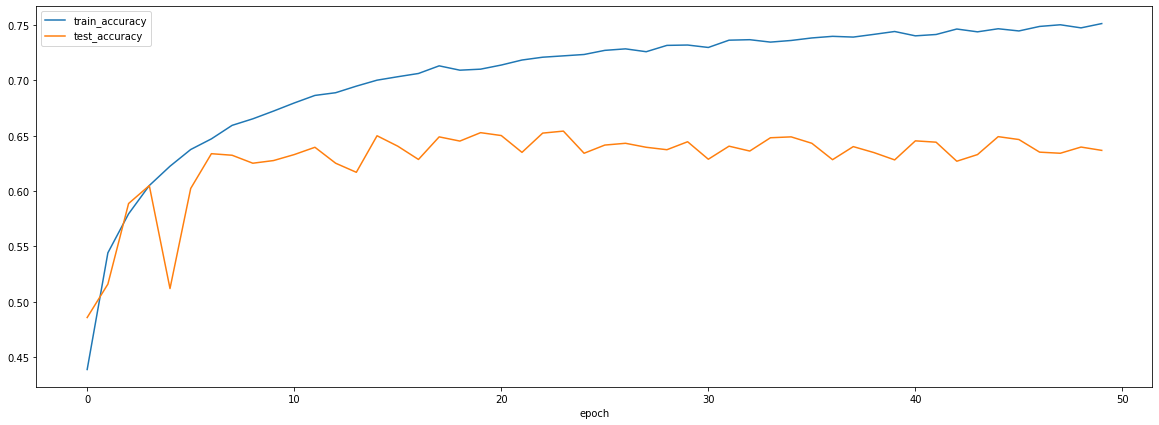

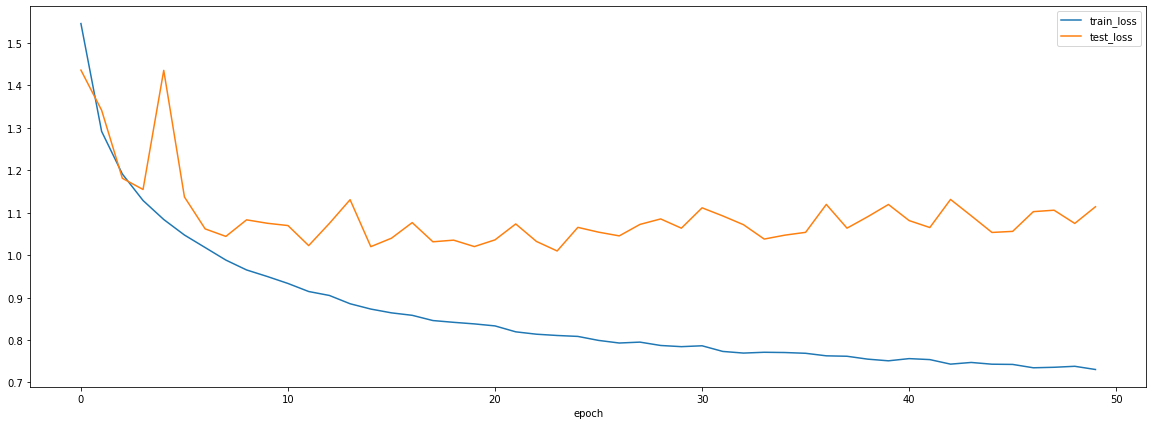

In [97]:

plt.figure(figsize=(20,7))
# plt.plot(df_history.plot.lines(),label=df_history.columns)
sns.lineplot(data=df_history[['train_accuracy','test_accuracy']], dashes=False)
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(20,7))
# plt.plot(df_history.plot.lines(),label=df_history.columns)
sns.lineplot(data=df_history[['train_loss','test_loss']], dashes=False)
plt.xlabel('epoch')
plt.show()

In [98]:

loss_valid_total = 0
predictions, true_valid = [], []
best_model.eval()
with torch.no_grad(): 
    progress_bar = tqdm.tqdm(dataloader_valid, desc='Valid: ', leave=False, disable=False)
    for bach in progress_bar:

        inputs, labels = bach
                
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward
        # print(inputs)
        outputs = best_model(inputs)

        valid_loss = criterion(outputs, labels)

        loss_valid_total += valid_loss.item()
        predictions.append(outputs.argmax(dim=-1, keepdim=True).cpu().numpy())
        true_valid.append(labels.cpu().numpy())

        progress_bar.set_postfix({'valid_loss': '{:.3f}'.format(valid_loss.item()/len(inputs))})

    loss_valid_avg = loss_valid_total/len(dataloader_valid)
    predictions = np.concatenate(predictions, axis=0)
    true_valid = np.concatenate(true_valid, axis=0)

    valid_f1 = f1_score(true_valid, predictions, average='weighted')
    valid_f1_macro = f1_score(true_valid, predictions, average='macro')
    valid_accuracy_score = accuracy_score(true_valid, predictions)
    tqdm.tqdm.write(f'valid loss: {valid_loss}')
    tqdm.tqdm.write(f'accuracy score: {valid_accuracy_score}')
    tqdm.tqdm.write(f'F1 Score (Weighted): {valid_f1}')
    tqdm.tqdm.write(f'F1 Score (Macro): {valid_f1_macro}')

valid loss: 1.1465455293655396
accuracy score: 0.6324
F1 Score (Weighted): 0.6366982164600721
F1 Score (Macro): 0.6366982164600721


In [99]:
c_matrix =  confusion_matrix(true_valid,predictions)

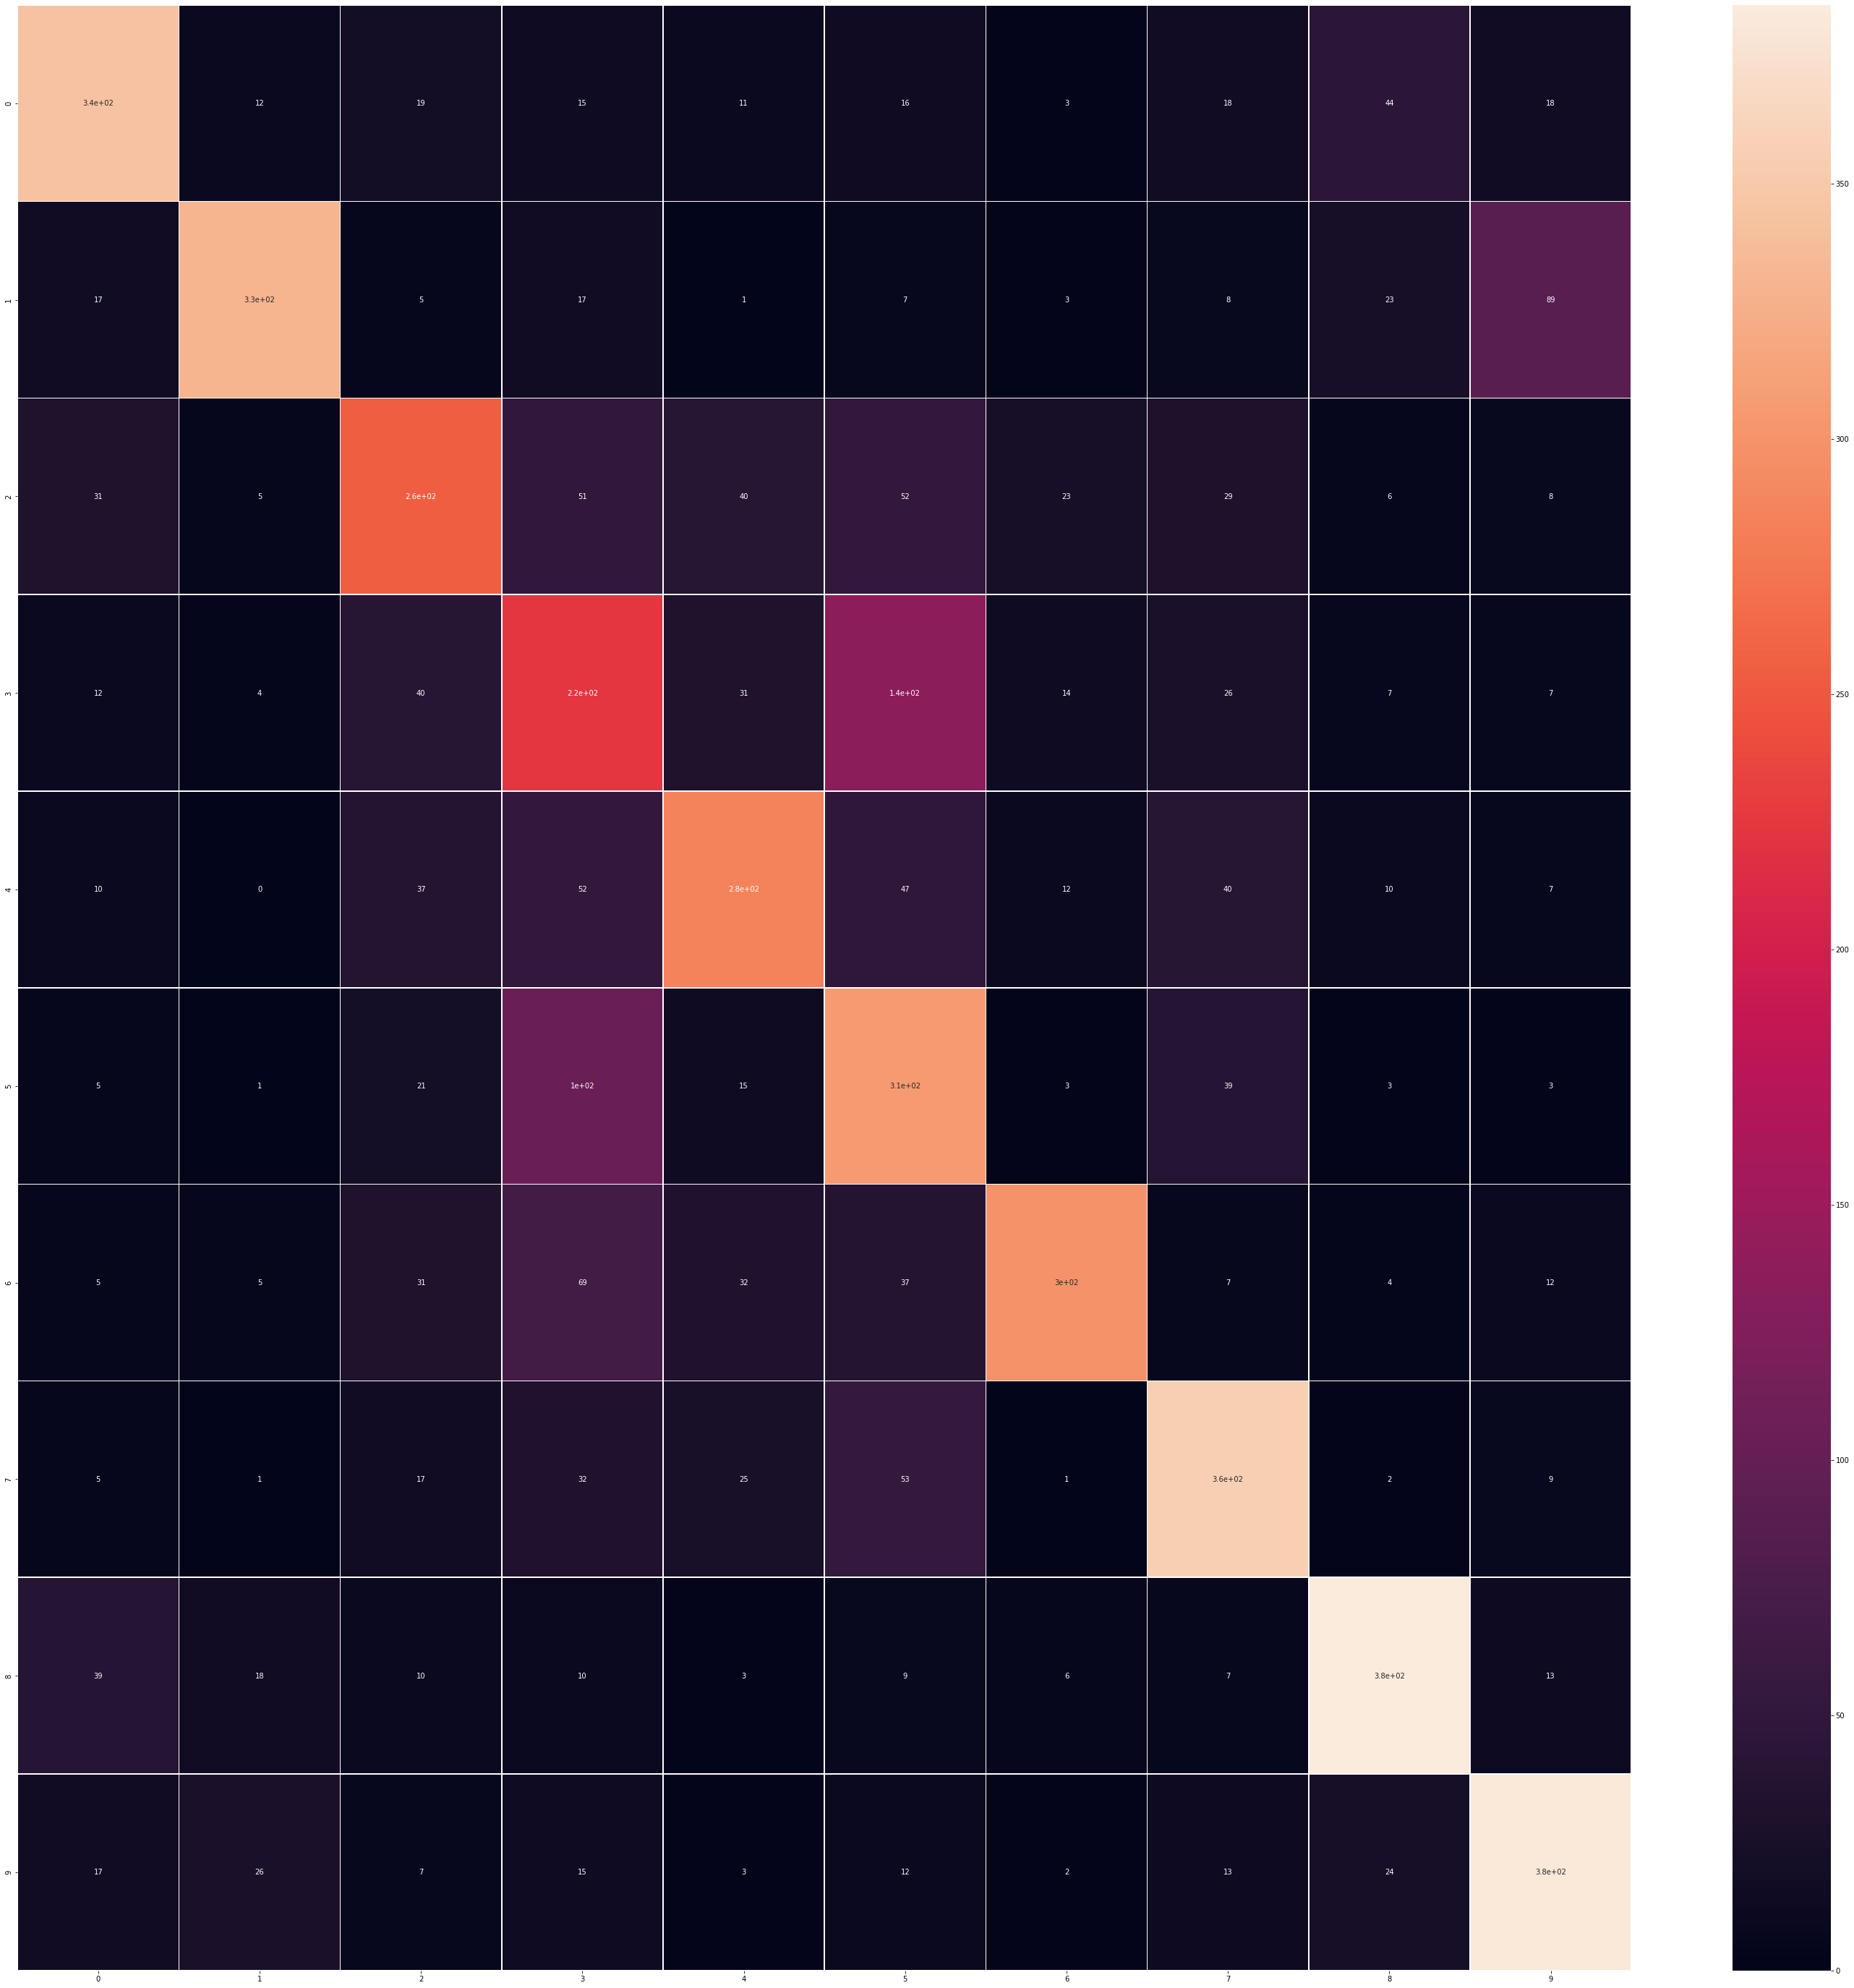

In [100]:
plt.figure(figsize=(50,50))
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(c_matrix, linewidth=0.5,annot=True)
plt.show()

In [101]:
print(classification_report(true_valid,predictions))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       500
           1       0.82      0.66      0.73       500
           2       0.58      0.51      0.54       500
           3       0.38      0.45      0.41       500
           4       0.64      0.57      0.60       500
           5       0.45      0.61      0.52       500
           6       0.82      0.60      0.69       500
           7       0.65      0.71      0.68       500
           8       0.76      0.77      0.76       500
           9       0.70      0.76      0.73       500

    accuracy                           0.63      5000
   macro avg       0.65      0.63      0.64      5000
weighted avg       0.65      0.63      0.64      5000

